# 3 - Building A Regression Model (Gradient Boosting)
Okay, so I've gotten to explore the data set a little bit, statistically and spatially. I now want to built a model. With the model, I'm not necessarily trying to predict anything, but I almost want to use regression as a means for data exploration and data visualization as well. In the ideal world, I'd want to see a heatmap like this:

<img src="http://s3.amazonaws.com/media.wbur.org/wordpress/1/files/2013/01/01_30heatmapboston1.jpg" style="width: 500px;"/>

This is a heatmap of Boston showing the price per bedroom. I essentially would like to build that for units in Edmonton.

Thinking about it, gmaps has a weighted heatmap option, but gmaps' heatmap factors in _**density**_. Sure, there is a weighted option, but you're still taking density into account. For example, the following 2 situations would probably yield the same result:
1. A block of 5 very expensive houses
2. A block of 50 less expensive houses

The heatmap yields some function of density and weight (assessment value), we need to purely look at the average assessment value in a region without taking into account the density.

## Gradient Boosting... Again?!
The first thought that came into my mind was actually xgboost... AGAIN. I've done 3 projects now, and all 3 have relied on xgboost haha... What a package. This is where my train of thought comes from:

When I was reading [ESL](http://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf), I came across this visualization which is doing exactly what I want to do here and it stuck in my mind:

![](https://s3.ca-central-1.amazonaws.com/2017edmfasatb/edmonton_property_assessment/images/esl_partial_dep_cali.png)

When I was reading the book, I didn't even know I wanted to do this kind of project, but that image still stuck with me. It was one of the moments when I realized that models are so divserse in the way that they function and often times the model may yield results that you never set out to accomplish. When I was reading about gradient boosting, I was like "great, this sounds like an awesome classification technique", but right now, not only am I working in the context of regression, but I don't even really want to use regression as a prediction technique going forward, I actually want to use it for a data exploration / visualization technique! Yes, regression is imperative to getting to our end goal of the visualization, but I'm really not trying to feed new data into here and predicting on them (although, as the tables flip, I will have a model to do that if I want to as a bonus)!

Well... we're no strangers to xgboost by now... let's git it.

In [1]:
# Enable plots in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# Seaborn makes our plots prettier
import seaborn
seaborn.set(style = 'ticks')

# Import jupyter widgets
from ipywidgets import widgets

import numpy as np
import pandas as pd
import os
import gmaps
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data set
edm_data = pd.read_csv('../data/Property_Assessment_Data.csv')

In [3]:
edm_data.dtypes

Account Number        int64
Suite                object
House Number        float64
Street Name          object
Assessed Value       object
Assessment Class     object
Neighbourhood        object
Garage               object
Latitude            float64
Longitude           float64
dtype: object

In [4]:
# Replace dollar signs and cast to int
edm_data['Assessed Value'] = edm_data['Assessed Value'].str.replace('$', '').astype(int)

In [5]:
edm_data['Assessed Value'].dtype

dtype('int64')

In [6]:
# Filter for only residential buildings
edm_data_res = edm_data[edm_data['Assessment Class'] == 'Residential']

In [7]:
# Import ML libraries
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

In [8]:
# Define x and y
x = edm_data_res[['Latitude', 'Longitude']].values
y = edm_data_res['Assessed Value'].values

print 'x has shape {}'.format(x.shape)
print 'y has shape {}'.format(y.shape)

x has shape (363373, 2)
y has shape (363373,)


In [9]:
# Hold out 10% for test data for early stopping
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

print 'x_train has shape {}'.format(x_train.shape)
print 'y_train has shape {}'.format(y_train.shape)
print 'x_test has shape {}'.format(x_test.shape)
print 'y_test has shape {}'.format(y_test.shape)

x_train has shape (290698, 2)
y_train has shape (290698,)
x_test has shape (72675, 2)
y_test has shape (72675,)


In [10]:
# # Instantiate model
# xgb_model = xgb.XGBClassifier()

# # Set parameters (for GridSearchCV, every value must be in a list, even if there is only 1 value we want to test)
# param_grid = {
#     'max_depth': [1],
#     'learning_rate': [0.05],
#     'objective': ['reg:linear'],
#     'silent': [1],
#     'n_estimators': [10000]
# }

# fit_params = {
#     'early_stopping_rounds': 300,
#     'eval_metric': 'rmse',
#     'eval_set': [[x_test, y_test]],
#     'verbose': 500
# }

# # Set up grid search
# clf = GridSearchCV(
#     xgb_model, 
#     param_grid, 
#     fit_params = fit_params,
#     n_jobs = -1, 
#     cv = 5, 
#     scoring = 'mean_squared_error',
#     verbose = 1, 
#     refit = True
# )

In [11]:
# # Fit model
# clf.fit(x_train, y_train)

Okay, wow, I'm having an extremely difficult time trying to get xgboost() to work with the objective 'reg:linear' and GridSearchCV...

I'm going to bypass GridSearchCV for now and revisit it later when I feel up to the challenge. I have to caveat what I'm about to do with the fact that I'm going off of previous models that I've built to pick the parameters here. _**IN NO WAY IS MY PARAMETER PICKING FOR THE BELOW CODE OPTIMAL**_. I would definitely be trying to use GridSearchCV to find the best parameters for max_depth and learning_rate.

Let's start our quick and dirty model train:

In [12]:
# Set up xgboost dense matrix for non-GridSearchCV implementation
xgb_train = xgb.DMatrix(x_train, label = y_train)
xgb_test = xgb.DMatrix(x_test, label = y_test)

# Set xgboost parameters
param = {
    'max_depth': 20,
    'learning_rate': 0.05,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'subsample': 0.8,
    'seed': 1
}

In [13]:
# Train model
bst = xgb.train(
    params = param, 
    dtrain = xgb_train, 
    num_boost_round = 10000, 
    evals = [(xgb_train, 'train'), (xgb_test, 'eval')], 
    early_stopping_rounds = 300,
    verbose_eval = 100
)

[0]	train-rmse:419623	eval-rmse:435246
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 300 rounds.
[100]	train-rmse:100525	eval-rmse:253754
[200]	train-rmse:86592	eval-rmse:254352
[300]	train-rmse:82291.2	eval-rmse:254653
Stopping. Best iteration:
[81]	train-rmse:109123	eval-rmse:253606



Ok, I feel a bit paranoid at the model because I can't tune the parameters, so I'm just going to randomly sample some parameter mappings. Note that there is no cross validation happening here, just a single train test split. Not quite as reliable but it's what I'm going to deal with for now.
- max_depth: 3, learning_rate: 0.03, subsample: 0.8 --> eval-rmse: <span style="color:red">278264</span> in 9999 iterations (no early stopping)
- max_depth: <span style="color:red">5</span>, learning_rate: 0.03, subsample: 0.8 --> eval-rmse: <span style="color:red">269331</span> in 8406 iterations (early stopping)
- max_depth: 5, learning_rate: <span style="color:red">0.1</span>, subsample: 0.8 --> eval-rmse: <span style="color:red">269342</span> in 2120 iterations (early stopping)
    - Looks like we can speed up the learning process for the most part, getting a similar error
- max_depth: <span style="color:red">6</span>, learning_rate: 0.1, subsample: 0.8 --> eval-rmse: <span style="color:red">267180</span> in 1234 iterations (early stopping)
- max_depth: <span style="color:red">7</span>, learning_rate: 0.1, subsample: 0.8 --> eval-rmse: <span style="color:red">264945</span> in 1363 iterations (early stopping)
- max_depth: <span style="color:red">8</span>, learning_rate: 0.1, subsample: 0.8 --> eval-rmse: <span style="color:red">261069</span> in 1969 iterations (early stopping)
    - Looks like the max_depth really helps the RMSE... let's go a bit crazy? I'm going to do it, but I have to stop to think a bit here... 20 is kinda nuts (well, as per my informal readings and research... generally people stick to 6-7), but I'm trying to contextualize it with the data we have at hand. We have an extremely complex grid, where every single house is basically it's own value... even within a neighbourhood, you could find houses for \$2M as well as \$500K... maybe 20 isn't so crazy _**relative to**_ to the grid we're trying to run regression on... I mean, regardless, our test error is going down... so let's keep going.
- max_depth: <span style="color:red">20</span>, learning_rate: 0.1, subsample: 0.8 --> eval-rmse: <span style="color:red">254117</span> in 29 iterations (early stopping)
- max_depth: <span style="color:red">100</span>, learning_rate: 0.1, subsample: 0.8 --> eval-rmse: <span style="color:red">253392</span> in 29 iterations (early stopping)
    - It really does kinda just keep getting better and better... but the trade off in training time is increasing. I'm going to draw a line here and just go with 20. I'm going to try tweaking the sampling rate a bit to see if that has any impact.
- max_depth: <span style="color:red">20</span>, learning_rate: 0.1, subsample: <span style="color:red">0.9</span> --> eval-rmse: <span style="color:red">256508</span> in 59 iterations (early stopping)
    - This is worse. I'm going to go back to 0.8 and as a last hail mary train a bit slower to see if that does anything. I've already gotten the error down by like 15% from when I started, so I'm quite happy.
- max_depth: 20, learning_rate: <span style="color:red">0.05</span>, subsample: <span style="color:red">0.8</span> --> eval-rmse: <span style="color:red">253606</span> in 81 iterations (early stopping)

Alright, so there's my make-shift parameter tuning... I'm going to go with that last model:
- max_depth: 20
- learning_rate: 0.05
- subsample: 0.8

It actually trains decently fast too, converging in just 81 iterations. If I think about this a bit more, each iteration is generating a tree with 20 splits (well, up to 20, but I'm sure it will find 20 splits that can optimize improve the training error) so we essentially have 1620 splits. We have to keep in mind that these 1620 splits are segregated into groups of 20, which are _**then improving upon the weaknesses of previous sets of splits**_, a la gradient boosting.

Awesome. Let's test it out on some samples:

In [14]:
# Generate statistics per neighborhood
edm_data_neighbour_grouped = edm_data_res.groupby(['Neighbourhood', 'Assessment Class']).agg({
    'Assessed Value': [np.mean, np.size],
    'Latitude': [np.mean],
    'Longitude': [np.mean]
}).reset_index()

In [15]:
# Show most valued neighbourhoods with greater than 20 units
most_valuable_50_neighbourhoods = edm_data_neighbour_grouped[edm_data_neighbour_grouped[('Assessed Value', 'size')] > 20].sort_values([('Assessed Value', 'mean')], ascending = False).head(50)
most_valuable_50_neighbourhoods.columns = most_valuable_50_neighbourhoods.columns.droplevel(-1)
most_valuable_50_neighbourhoods.columns = ['Neighbourhood', 'Assessment Class', 'Latitude', 'Assessment Value Mean', 'Units', 'Longitude']
most_valuable_50_neighbourhoods.head()

,Neighbourhood,Assessment Class,Latitude,Assessment Value Mean,Units,Longitude
313,THE UPLANDS,Residential,53.465887,2.974396e+06,24,-113.658513
196,MAPLE RIDGE INDUSTRIAL,Residential,53.503755,1.095500e+06,21,-113.351915
330,WESTBROOK ESTATE,Residential,53.469744,1.002055e+06,338,-113.548747
269,RIVERVIEW AREA,Residential,53.428226,8.794038e+05,156,-113.669871
341,WINDSOR PARK,Residential,53.524560,8.749425e+05,583,-113.534766


Let's feed the average latitude and longitude of these neighbourhoods into the model and see if it returns something close to the average Assessed Value.

In [16]:
# Extract the features and rename to what the model is trained on
top_50_neighbourhoods_test_x = most_valuable_50_neighbourhoods[['Latitude', 'Longitude']]
top_50_neighbourhoods_test_x.columns = ['f0', 'f1']
top_50_neighbourhoods_test_xgb = xgb.DMatrix(top_50_neighbourhoods_test_x)

In [17]:
# Make predictions
most_valuable_50_neighbourhoods['Predicted Value'] = bst.predict(top_50_neighbourhoods_test_xgb)

In [18]:
# Check results
most_valuable_50_neighbourhoods.head()

,Neighbourhood,Assessment Class,Latitude,Assessment Value Mean,Units,Longitude,Predicted Value
313,THE UPLANDS,Residential,53.465887,2.974396e+06,24,-113.658513,4.884999e+05
196,MAPLE RIDGE INDUSTRIAL,Residential,53.503755,1.095500e+06,21,-113.351915,1.117105e+06
330,WESTBROOK ESTATE,Residential,53.469744,1.002055e+06,338,-113.548747,7.936061e+05
269,RIVERVIEW AREA,Residential,53.428226,8.794038e+05,156,-113.669871,9.961632e+05
341,WINDSOR PARK,Residential,53.524560,8.749425e+05,583,-113.534766,1.387375e+06


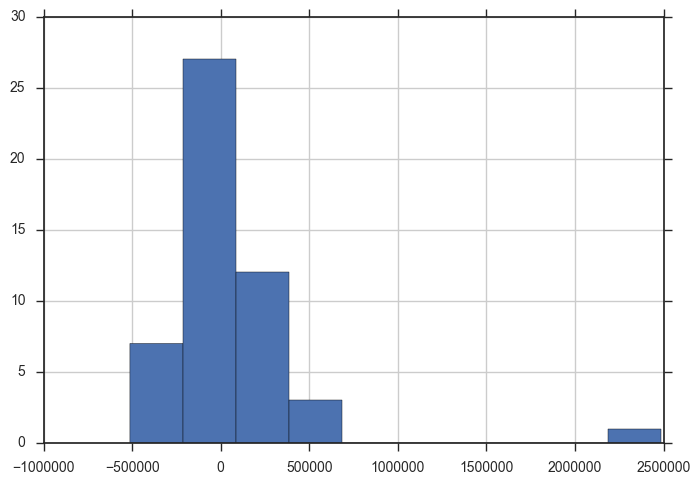

In [19]:
# Plot variances
most_valuable_50_neighbourhoods['Variance'] = most_valuable_50_neighbourhoods['Assessment Value Mean'] - most_valuable_50_neighbourhoods['Predicted Value']
most_valuable_50_neighbourhoods['Variance'].hist()

In some cases, the model was off by half a million, which kinda sucks. These, however, are the most expensive communities and may be quite unstable in terms of where the average latitude and longitude of the communities lies. Let's try this for all the communities. The fact that the histogram centers at zero is a great sign though, clearly there is correlation here and it's not just random noise.

In [20]:
# Show all neighbourhoods with greater than 20 units
neighbourhoods = edm_data_neighbour_grouped[edm_data_neighbour_grouped[('Assessed Value', 'size')] > 20].sort_values([('Assessed Value', 'mean')], ascending = False)
neighbourhoods.columns = neighbourhoods.columns.droplevel(-1)
neighbourhoods.columns = ['Neighbourhood', 'Assessment Class', 'Latitude', 'Assessment Value Mean', 'Units', 'Longitude']
neighbourhoods.tail()

,Neighbourhood,Assessment Class,Latitude,Assessment Value Mean,Units,Longitude
234,PEMBINA,Residential,53.601348,100976.420798,827,-113.545760
195,MAPLE RIDGE,Residential,53.501823,81647.368421,855,-113.362575
113,EVERGREEN,Residential,53.631798,63883.164006,689,-113.351332
333,WESTVIEW VILLAGE,Residential,53.552301,60355.477855,858,-113.696537
325,WEIR INDUSTRIAL,Residential,53.511274,13673.076923,52,-113.411331


In [21]:
# Extract the features and rename to what the model is trained on
neighbourhoods_test_x = neighbourhoods[['Latitude', 'Longitude']]
neighbourhoods_test_x.columns = ['f0', 'f1']
neighbourhoods_test_xgb = xgb.DMatrix(neighbourhoods_test_x)

In [22]:
# Make predictions
neighbourhoods['Predicted Value'] = bst.predict(neighbourhoods_test_xgb)

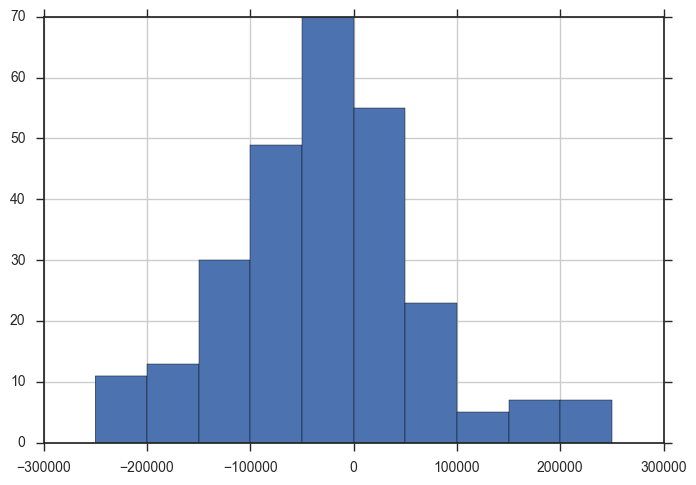

In [23]:
# Plot variances
neighbourhoods['Variance'] = neighbourhoods['Assessment Value Mean'] - neighbourhoods['Predicted Value']
neighbourhoods['Variance'].hist(range = [-250e3, 250e3])

Confirmed. This thing is doing quite alright. Most guesses are within 100K of the right valuation. I have a crazy idea that might just work in creating the heat map. The California plot above uses the partial dependency plots to generate that type of heatmap, but unfortunately to me, xgboost doesn't have partial dependency capabilities yet.

There are two correlated facts sticking out in my head:
- I need to take out denstiy from the equation, I need equally distributed points representing the average value
- I can now calculate the average value for a series of points

Why don't I... create a grid of points across the entire city and use my model to predict the average value? Wouldn't that essentially be showing me the type of relationships that my model is generating?

Judging by Google Maps, Edmonton is about:
- ~28km wide (E-W) from -113.297595 to -113.709582
- ~30km tall (N-S) from 53.396169 to 53.672860

What if we created a grid of 100 x 100 points throughout the city to predict and plot on? Let's try it out:

In [480]:
# Define city boundaries
lng_min = -113.709582
lng_max = -113.297595
lat_min = 53.396169
lat_max = 53.672860

# Set padding if we want to expand map by certain amount
map_padding = 0
lng_min -= map_padding
lng_max += map_padding
lat_min -= map_padding
lat_max += map_padding

# Number of steps
num_steps = 50

# Calculate step sizes
lng_step_size = (lng_max - lng_min) / num_steps
lat_step_size = (lat_max - lat_min) / num_steps

print 'Longitude step size: {}'.format(lng_step_size)
print 'Latitude step size: {}'.format(lat_step_size)

Longitude step size: 0.00823974
Latitude step size: 0.00553382


In [481]:
# Import geopy
from geopy.distance import vincenty

# Generate grid of lat / long points
lat_lng_threshold = 1000

lng_pts = []
lat_pts = []

total_points = num_steps**2

i = 0
for lng in np.arange(lng_min, lng_max, lng_step_size):
    for lat in np.arange(lat_min, lat_max, lat_step_size):
        # Print only every cluster of iterations
        if i % 100 == 0:
            print 'Iteration {} / {}'.format(i, total_points)
        
        # Only keep point on grid if it's within 1km distance of a community
        neighbourhoods['Lat Lng Tuple'] = neighbourhoods[['Latitude', 'Longitude']].apply(tuple, axis = 1)
        neighbourhoods['Distance'] = neighbourhoods['Lat Lng Tuple'].apply(lambda x: vincenty(x, (lat, lng)).meters)

        if (neighbourhoods['Distance'].min() <= lat_lng_threshold):
            lng_pts.append(lng)
            lat_pts.append(lat)
        
        i += 1

Iteration 0 / 2500
Iteration 100 / 2500
Iteration 200 / 2500
Iteration 300 / 2500
Iteration 400 / 2500
Iteration 500 / 2500
Iteration 600 / 2500
Iteration 700 / 2500
Iteration 800 / 2500
Iteration 900 / 2500
Iteration 1000 / 2500
Iteration 1100 / 2500
Iteration 1200 / 2500
Iteration 1300 / 2500
Iteration 1400 / 2500
Iteration 1500 / 2500
Iteration 1600 / 2500
Iteration 1700 / 2500
Iteration 1800 / 2500
Iteration 1900 / 2500
Iteration 2000 / 2500
Iteration 2100 / 2500
Iteration 2200 / 2500
Iteration 2300 / 2500
Iteration 2400 / 2500


In [482]:
len(lng_pts)

1385

In [483]:
# Generate input xgb dense matrix
x_edm_grid_test = pd.DataFrame({
    'f0': lat_pts,
    'f1': lng_pts
})

edm_grid_test_xgb = xgb.DMatrix(x_edm_grid_test)

In [484]:
# Make predictions
x_edm_grid_test['y_edm_grid_pred'] = bst.predict(edm_grid_test_xgb)

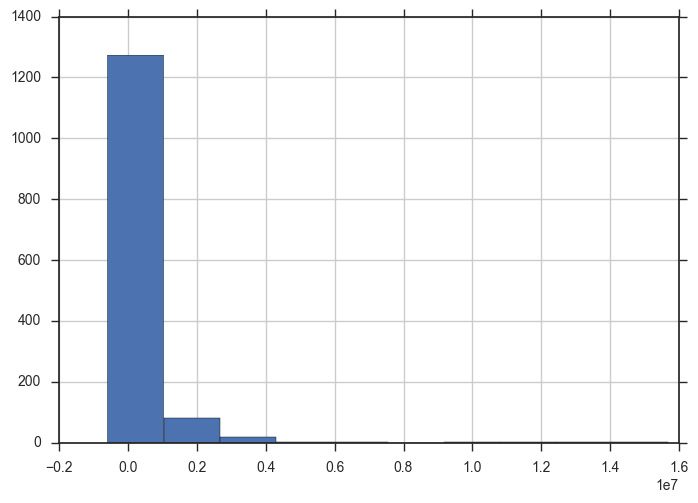

In [485]:
# Look at distribution of predictions
x_edm_grid_test['y_edm_grid_pred'].hist()

Now I want the value to represent the intensity of the color on the heat map, right? This is extremely unproportional as that \$20M house will blow all the other houses out of the water in terms of color intensity. Let's try taking a log scale.

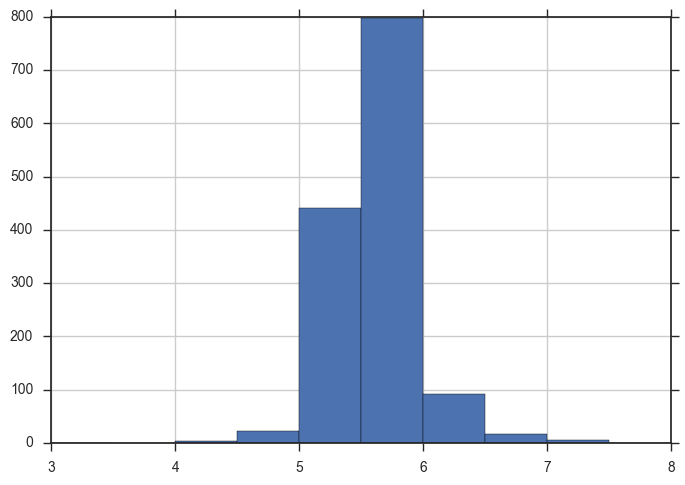

In [486]:
# Look at distribution of log predictions
x_edm_grid_test['y_edm_grid_pred'].apply(lambda x: np.sign(x)*(np.log10(np.abs(x)+1))).hist(range = [3, 8])

Above, I'm using a _**log modulus**_ calculation, which performs the log transformation equally for _**positive and negative values**_. This, of course, is important because your average log calculation does not handle negative values. Log modulus has the effect of something like this:

<img src="http://blogs.sas.com/content/iml/files/2014/07/logmodulus2.png" style="width: 500px;"/>

This looks great. Getting rid of the outliers, although the lower half of this Gaussian is a bit misleading... I just have to remember that this _**is on a log scale**_.

In [487]:
# Create new log column
x_edm_grid_test['y_edm_grid_pred_log'] = x_edm_grid_test['y_edm_grid_pred'].apply(lambda x: np.sign(x)*(np.log10(np.abs(x)+1)))

In [488]:
# Remove heavy outliers on the negative side
x_edm_grid_test_no_outliers = x_edm_grid_test[x_edm_grid_test['y_edm_grid_pred_log'].between(3, 8)]

In [489]:
# Scale responese from 0 to 1 to match gmaps opacity parameter
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

x_edm_grid_test_no_outliers['y_edm_grid_pred_log_scaled'] = scaler.fit_transform(x_edm_grid_test_no_outliers['y_edm_grid_pred_log'])

/Users/chiwang/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/chiwang/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [490]:
# Check results
x_edm_grid_test_no_outliers_sample = x_edm_grid_test_no_outliers.head(5)
x_edm_grid_test_no_outliers_sample

,f0,f1,y_edm_grid_pred,y_edm_grid_pred_log,y_edm_grid_pred_log_scaled
0,53.517913,-113.709582,2.060284e+06,6.313927,0.694945
1,53.528981,-113.709582,8.496143e+05,5.929222,0.561743
3,53.540048,-113.709582,2.850696e+06,6.454951,0.743774
4,53.551116,-113.709582,6.362494e+05,5.803628,0.518257
5,53.556650,-113.709582,8.744093e+05,5.941715,0.566069


In [491]:
# Import gmaps library and initial config
import gmaps
gmaps.configure(api_key=os.environ["GOOGLE_API_KEY"])

In [501]:
# Plot gmaps
edm_grid_heatmap = gmaps.heatmap_layer(
    x_edm_grid_test_no_outliers[['f0', 'f1']], 
    max_intensity = 10,
    weights = np.array(x_edm_grid_test_no_outliers['y_edm_grid_pred_log_scaled'].tolist())*8.5
    ,
    opacity = 0.4
)

edm_grid_fig = gmaps.figure()
edm_grid_fig.add_layer(edm_grid_heatmap)
edm_grid_fig

First things first. The annoying thing about taking a grid sample and making predictions off that grid is that it's not dynamic to map zooms unfortunately... If you zoom in once from the default map, you should be able to see the heatmap the way I intended lol. For jupyer and web purposes, the intended heatmap is below:

![](https://s3.ca-central-1.amazonaws.com/2017edmfasatb/edmonton_property_assessment/images/xgboost_heatmap.png)

Alright, so what do we have here... I have to remember that this is a log scale, so the really red areas are actually worth _**more**_ than what their intensity seems to be. My objective here, however, is not to get into all the numbers. It's simply to get an overall perspective on where the "hot spots" are in terms of property value. To no surprise, Edmonton SW seems like a clear winner, with other areas of the city showing pockets of value as well.

One trend I see is that properties are pretty much expensive all along the river, all the way from "Beverly" in the NE to "Woodbend" in the SW. Probably the largest patch of expensive properties are the ones along the river that are also central to the city, around the U of A area.

I'd say our gradient boosting model produced something that at least _**makes sense**_. I'm not in real estate and I'm not too well-travelled even in my home city, so I can't quite comment on certain areas of the map, but the southside looks pretty accurate to me.

Another thing I'm noticing is that there's a big glaring green hole in downtown. This is based on the fact that each _**condo unit**_ is being compared against each _**house**_, which obviously is not a fair comparison. I haven't done any splitting of the data to ensure that houses are compared against houses and condos are compared against condos. Downtown, a dense area of condos, will obviously have a lower value per unit than the suburbs of Edmonton. Maybe a modification for later!

For now, though, I want to try another model really quick. Let's see if KNN gives us a similar result!